# Narrative Flow of Men and Women



 ### Hypothesis:

Men and women discuss sociability and solidarity in different ways, i.e. in different contexts. (..) Solidarity and social relations were different in the men and women section of Birkenau; men and women recall them in different ways and contexts. In practice, this means that they are primed and followed by different topics in the narratives of men and women.

If the hypothesis is true:
- the story line (or narrative flow) leading to the discussion of sociability and solidarity is different in testimonies of men and women
- the most likely sequences of topics (to be named narrative pathway) leading to topics describing solidarity and sociability are different
- different amount of traffic is going through  similar pathways leading to solidarity and sociability
- different nodes (to be named priming topics) are preceding and following (to be named exit topics) topics of solidarity and sociability


Key research questions to be studied here:
- What are the major pathways between the memory of arrival to Birkenau and leaving from Birkenau?
- How are nodes related to solidarity (food sharing, aid giving) and social bonds (friends, social bonds, family) are situated along the major pathways? For women and men, are they peripheral or central? I.e. do a significant amount of narrative flow go towards them for men and women?
- What are the exit and priming topics for solidarity (food sharing, aid giving) and social bonds for men and women?
- How are these topics related to survival explanations?
- How is friendship related to aid giving for men and for women? What are the transitory topics between them?
- What are those topics that prime topics of solidarity and social bonds?
- Where did solidarity take place? In what contexts did solidarity take place?
- What topics do topics related to solidarity and social bonds prime for men and women?


In [1]:
import constants
import pandas as pd
import os
from IPython.display import display
import json
import pyemma
from tables import *
import sys; sys.path.insert(0, '..')
from markov_modelling.markov_utils import *

In [2]:
# define the Uwe
edge_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("uwe",
                                                                    [(0, 0, 0, .1), (0, 0, 0, 1)])

## Load the relevant data

Load interview

Set up the paths to data

Two different datasets were created. In Dataset 1, the topic 'social bonds' include 'friendship' as well; similarly the topic 'aid giving' includes 'food sharing'. In Dataset 2, 'friendship' and 'food sharing' are distinguished, and they are different topics.

First, load Dataset 1

In [3]:
input_directory = constants.output_data_markov_modelling
path = os.getcwd()
parent = os.path.abspath(os.path.join(path, os.pardir))
input_directory = parent +'/'+ constants.output_data_markov_modelling
data_set_1_w  = pyemma.load(input_directory+'complete_w'+'/'+'pyemma_model','simple')
data_set_1_m = pyemma.load(input_directory+'complete_m'+'/'+'pyemma_model','simple')
data_set_1_complete = pyemma.load(input_directory+'complete'+'/'+'pyemma_model','simple')
input_directory = parent +'/'+ constants.output_data_segment_keyword_matrix
features_df = pd.read_csv(input_directory+constants.output_segment_keyword_matrix_feature_index)
features_df = features_df.drop(columns=['Unnamed: 0','index'])

Load Dataset 2

In [4]:
input_directory = 'data/output_aid_giving_sociability_expanded/markov_modelling/'

path = os.getcwd()
parent = os.path.abspath(os.path.join(path, os.pardir))
input_directory = parent +'/'+ input_directory
data_set_2_w  = pyemma.load(input_directory+'complete_w'+'/'+'pyemma_model','simple')
data_set_2_m = pyemma.load(input_directory+'complete_m'+'/'+'pyemma_model','simple')
data_set_2_complete = pyemma.load(input_directory+'complete'+'/'+'pyemma_model','simple')
input_directory = parent +'/'+ 'data/output_aid_giving_sociability_expanded/segment_keyword_matrix/'
features_df_2 = pd.read_csv(input_directory+constants.output_segment_keyword_matrix_feature_index)
features_df_2 = features_df_2.drop(columns=['Unnamed: 0','index'])


In [5]:
def get_graphs_msms(msm_stringformat, story_start, story_end, fraction=.95):
    if msm_stringformat.find('1') > 0:
        _features_df = features_df
    else:
        _features_df = features_df_2

    msm = eval(msm_stringformat)
    graph, tpt, pos = get_tpt_major_flux(msm, _features_df, story_start, story_end,
                                         fraction=fraction,)

    return graph, tpt, msm, _features_df

def downsize_nodename_dict(_features_df, msm, subgraph):
    nodename_dict = {i:_features_df.iloc[j].KeywordLabel for i, j in enumerate(msm.active_set)}
    nodename_dict_inv = {v:k for k, v in nodename_dict.items()}
    spathg_nodes = [nodename_dict_inv[k] for k in list(subgraph.nodes)]

    return spathg_nodes


def get_subgraph_around_topic(pathgraph, to_analyze):
    """
    returns sub-graph around a topic with only links into and out of that topic
    """
    neighbors = [to_analyze] + \
                list(pathgraph.successors(to_analyze)) + \
                list(pathgraph.predecessors(to_analyze))
    
    subgraph = nx.DiGraph()
    
    subgraph.add_nodes_from(neighbors)
    allweights = nx.get_edge_attributes(pathgraph, 'weight')
    
    for edges in [pathgraph.in_edges(to_analyze), pathgraph.out_edges(to_analyze)]:
        for edge in edges:
            subgraph.add_edge(*edge, weight=allweights[edge])

    sweights = np.array(list(nx.get_edge_attributes(subgraph, 'weight').values())).astype(float)

    return subgraph, sweights

def plot_small_graph(ax, subgraph, subgraph_weights, probabilities, fruchterman_layout=False):
    if fruchterman_layout:
        subgraph_pos = nx.fruchterman_reingold_layout(subgraph, k=1e-1)
    else:
        subgraph_pos = {to_analyze:np.array([0, 0])}
        
        succ = list(subgraph.successors(to_analyze))
        y_succ = np.linspace(-2, 2, len(succ))
        subgraph_pos.update({n:np.array([1, y_succ[n_]]) for n_, n in enumerate(succ)})
        
        predec = list(subgraph.predecessors(to_analyze))
        y_predec = np.linspace(-2, 2, len(predec))
        subgraph_pos.update({n:np.array([-1, y_predec[n_]]) for n_, n in enumerate(predec)})
                                                  
    nx.draw_networkx_nodes(subgraph, subgraph_pos, 
                           node_size=probabilities*10000, 
                           ax=ax, )
    nx.draw_networkx_labels(subgraph, 
                            {k:v+np.array([0,.2]) for k,v in subgraph_pos.items()}, 
                            ax=ax,
                            labels={n:n for n in list(subgraph.nodes)}, font_size=9)

    nx.draw_networkx_edges(subgraph, subgraph_pos, 
                           node_size=probabilities*10000,
                           edge_cmap=edge_cmap, 
                        edge_color=subgraph_weights, width=2.7, ax=ax);
    ax.axis('off')
    ax.set_xlim(-1.75, 1.75)
    
def print_reactive_pathways_through_node(node, _features_df, msm, tpt, n_paths=3, fraction=0.95):
    nodename_dict = {i:_features_df.iloc[j].KeywordLabel for i, j in enumerate(msm.active_set)}
    paths, capacities = tpt.pathways(fraction)

    n_found = 0
    for n, (path, cap) in enumerate(zip(paths, capacities)):
        pathname_path = [nodename_dict[msm._full2active[i]] for i in path]
        if to_analyze in pathname_path:
            _printpath = [p if p!= node else p.upper() for p in pathname_path]
            print(f'rank: {n}; capacity: {cap}\npath:{_printpath}')
            n_found += 1
        if n_found == n_paths:
            break
            
    if n_found < n_paths:
        print(f'no more paths through {node} in {100*fraction}% of reactive paths')
    return

## Observation 1

### Qualitative description

For women, the main topic that primes the discussion of aid giving is the discussion of the living conditions. By contrast, the most important topic that primes aid giving for men is the discussion of forced labour activity. 

For women, the most important narrative trajectory leading to the discussion of aid giving is the following one (8.3 % of the total traffic is going through it):
- arrival-camp intake procedures-living conditions-aid giving

For men, the most important narrative trajectory leading to the discussion of aid giving is the following one (5 % of the total traffic is going through it):
- arrival-selections-camp intake procedures-living conditions-forced labor-aid giving

Both men and women discuss aid giving in the context of camp living conditions and forced labour, women are more likely to discuss it in the context of camp living conditions. While men are more likely to discuss it in the context of forced labour.

NameError: name 'get_tpt_major_flux' is not defined

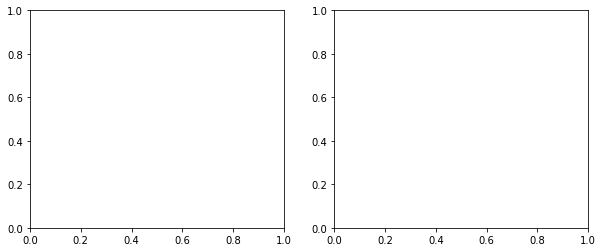

In [6]:
story_start = 'arrival'
story_end = 'departure'
to_analyze = 'aid giving'

msms_str = ['data_set_1_m', 'data_set_1_w']


fig, axes = plt.subplots(1, 2, figsize=(10, 4))


for ax, name in zip(axes, msms_str):
    graph, tpt, msm, _features_df = get_graphs_msms(name, story_start, story_end)
    print(name)
    print_reactive_pathways_through_node(to_analyze, _features_df, msm, tpt)
    
    subgraph, subgraph_weights = get_subgraph_around_topic(graph, to_analyze)

    spathg_nodes = downsize_nodename_dict(_features_df, msm, subgraph)
    
    
    plot_small_graph(ax, subgraph, subgraph_weights, msm.pi[spathg_nodes])
    ax.set_title(name)
    
    print()

## Observation 2

### Qualitative description

As above, a key topic that follows the discussion of aid giving is forced labour. However, this has different weight in the narratives of men and women. Men are more likely to discuss forced labour following aid giving. In testimonies of men, more traffic is going through the following pathway (3,6% women versus 6,2% men):

-aid giving-forced labor-departure.

## Observation 3

### Qualitative description

Similarly to aid giving, women tend to discuss food sharing in the context of living conditions, whereas men discuss it in the context of forced labour. For women, food sharing is most likely to be primed by the discussion of living conditions, for men food sharing tends to be primed by forced labour. In testimonies of women, the major traffic (16,5%) towards food sharing are going through the following two pathways:
- arrival-camp intake procedures-living conditions-food and thirst-food sharing
- arrival-selections-camp intake procedures-living conditions-food sharing

By contrast, in testimonies of men, the major traffic ( 11.33405389131642%) towards food sharing are going through the following pathways:
- arrival-selections-camp intake procedures-living conditions-forced labor-food sharing




### Visualization

In [ ]:
story_start = 'arrival'
story_end = 'departure'
to_analyze = 'food sharing'

msms_str = ['data_set_2_m', 'data_set_2_w']


fig, axes = plt.subplots(1, 2, figsize=(10, 4))


for ax, name in zip(axes, msms_str):
    graph, tpt, msm, _features_df = get_graphs_msms(name, story_start, story_end)
    print(name)
    print_reactive_pathways_through_node(to_analyze, _features_df, msm, tpt)
    
    subgraph, subgraph_weights = get_subgraph_around_topic(graph, to_analyze)

    spathg_nodes = downsize_nodename_dict(_features_df, msm, subgraph)
    
    plot_small_graph(ax, subgraph, subgraph_weights, msm.pi[spathg_nodes])
    ax.set_title(name)
    print()

## Observation 4

### Qualitative description

In testimonies of men and women, different topics are the ones that are most likely to follow food sharing. The topic that is the most likely to follow food sharing in women testimonies is again living conditions. By contrast men tend to discuss forced labour and selection following food sharing.

## Observation 5

### Qualitative description

In narratives of women, the discussion of friendship tends to be preceded by the discussion of living environments and housing conditions. Very different amount of traffic is going through the following two narrative pathways :

- Women (12.2%):arrival-camp intake procedures-living conditions-friends
- Men (5.2%): arrival-selections-camp intake procedures-living conditions-friends



In [ ]:
story_start = 'arrival'
story_end = 'departure'
to_analyze = 'friends'

msms_str = ['data_set_2_m', 'data_set_2_w']


fig, axes = plt.subplots(1, 2, figsize=(10, 4))


for ax, name in zip(axes, msms_str):
    graph, tpt, msm, _features_df = get_graphs_msms(name, story_start, story_end)
    print(name)
    print_reactive_pathways_through_node(to_analyze, _features_df, msm, tpt)
    
    subgraph, subgraph_weights = get_subgraph_around_topic(graph, to_analyze)

    spathg_nodes = downsize_nodename_dict(_features_df, msm, subgraph)
    
    plot_small_graph(ax, subgraph, subgraph_weights, msm.pi[spathg_nodes])
    ax.set_title(name)
    print()

### Qualitative description

In narratives of women, the most immediate topic that follows the discussion of friendship is living conditions; this pattern is very weakly present in testimonies of men.


## Observation 7

## Qualitative description

If we look at all possible narrative pathways that can connect arrival to and departure from Birkenau, we  can see that a significant amount of traffic is going through aid giving (4%) and social bonds (3.85%). Their significance can be understood if they are compared to Appel, where 9% of traffic is going through. The amount of traffic going through friendship (0.43%) and food sharing (0.48%) is less significant. I

In case of women, more traffic is going through these nodes, with an exception of food sharing:

- social bonds: 3.9 %
- aid giving: 5 %
- friendship: 0.71
- food sharing:  0.41 %

In case of men, less traffic is going through these nodes:

- social bonds: 3 %
- aid giving: 4 %
- friendship: 0.27
- food sharing:  0.53 %

#### Total traffic going through them in the complete dataset (men and women):

In [ ]:
story_start = 'arrival'
story_end = 'departure'
flux = 1
flux_complete = calculate_flux(data_set_1_complete,
                               features_df.KeywordLabel.to_list(),
                               [story_start],[story_end],
                               fraction=flux)
flux_complete_dataset_2 = calculate_flux(data_set_2_complete,
                                         features_df_2.KeywordLabel.to_list(),
                                         [story_start],[story_end],
                                         fraction=flux)


In [ ]:
flux_complete

Calculate the total traffic going through social bonds

In [ ]:
total_social_bonds = []
total_aid_giving = []
total_appell = []
total_friends = []
total_food_sharing = []
total_escapes = []

In [ ]:
for i,element in enumerate(flux_complete):
    if 'social bonds' in element.split('-'):
        total_social_bonds.append(flux_complete[element])
print(np.array(total_social_bonds).sum())

Calculate the total traffic going through aid giving

In [ ]:
for i,element in enumerate(flux_complete):
    if 'aid giving' in element.split('-'):
        total_aid_giving.append(flux_complete[element])
print(np.array(total_aid_giving).sum())

Calculate the total traffic going through Appell

In [ ]:
for i,element in enumerate(flux_complete):
    if 'Appell' in element.split('-'):
        total_appell.append(flux_complete[element])
print(np.array(total_appell).sum())

Calculate the total traffic going through escape

In [ ]:
for i,element in enumerate(flux_complete):
    if 'escapes' in element.split('-'):
        total_escapes.append(flux_complete[element])
print(np.array(total_escapes).sum())

Calculate the total traffic going through friendship

In [ ]:
for i,element in enumerate(flux_complete_dataset_2):
    if 'friends' in element.split('-'):
        total_friends.append(flux_complete_dataset_2[element])
print(np.array(total_friends).sum())

Calculate the total traffic going through food sharing

In [ ]:
for i,element in enumerate(flux_complete_dataset_2):
    if 'food sharing' in element.split('-'):
        total_food_sharing.append(flux_complete_dataset_2[element])
print(np.array(total_food_sharing).sum())

#### Total traffic going through them in the dataset of women

In [ ]:
story_start = 'arrival'
story_end = 'departure'
flux = 1
flux_w = calculate_flux(data_set_1_w,features_df.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)
flux_w_dataset_2 = calculate_flux(data_set_2_w,features_df_2.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)


In [ ]:
total_social_bonds = []
total_aid_giving = []
total_appell = []
total_friends = []
total_food_sharing = []

Calculate the total traffic going through social bonds

In [ ]:
for i,element in enumerate(flux_w):
    if 'social bonds' in element.split('-'):
        total_social_bonds.append(flux_w[element])
print(np.array(total_social_bonds).sum())

Calculate the total traffic going through aid giving

In [ ]:
for i,element in enumerate(flux_w):
    if 'aid giving' in element.split('-'):
        total_aid_giving.append(flux_w[element])
print(np.array(total_aid_giving).sum())

Calculate the total traffic going through friendship

In [ ]:
for i,element in enumerate(flux_w_dataset_2):
    if 'friends' in element.split('-'):
        total_friends.append(flux_w_dataset_2[element])
print(np.array(total_friends).sum())

Calculate the total traffic going through food sharing

In [ ]:
for i,element in enumerate(flux_w_dataset_2):
    if 'food sharing' in element.split('-'):
        total_food_sharing.append(flux_w_dataset_2[element])
        print (element)
        print (flux_w_dataset_2[element])
print(np.array(total_food_sharing).sum())

#### Total traffic going through them in the dataset of men

In [ ]:
story_start = 'arrival'
story_end = 'departure'
flux = 1
flux_m = calculate_flux(data_set_1_m,features_df.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)
flux_m_dataset_2 = calculate_flux(data_set_2_m,features_df_2.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)


In [ ]:
total_social_bonds = []
total_aid_giving = []
total_appell = []
total_friends = []
total_food_sharing = []



Calculate the total traffic going through social bonds

In [ ]:
for i,element in enumerate(flux_m):
    if 'social bonds' in element.split('-'):
        total_social_bonds.append(flux_m[element])
print(np.array(total_social_bonds).sum())

Calculate the total traffic going through aid giving

In [ ]:
for i,element in enumerate(flux_m):
    if 'aid giving' in element.split('-'):
        total_aid_giving.append(flux_m[element])
print(np.array(total_aid_giving).sum())

Calculate the total traffic going through friendship

In [ ]:
for i,element in enumerate(flux_m_dataset_2):
    if 'friends' in element.split('-'):
        total_friends.append(flux_m_dataset_2[element])
print(np.array(total_friends).sum())

Calculate the total traffic going through food sharing

In [ ]:
total_food_sharing = []

In [ ]:
for i,element in enumerate(flux_m_dataset_2):
    if 'food sharing' in element.split('-'):
        print (element)
        print (flux_m_dataset_2[element])
        total_food_sharing.append(flux_m_dataset_2[element])
print(np.array(total_food_sharing).sum())

## Observation 8

### Qualitative Description

In testimonies of women there are important narrative pathways that lead to the discussion of survival explanations and involve social bonds and aid giving as states preceding survival explanations; in testimonies of men such paths have significantly less traffic. We can see a similar pattern with friends and food sharing, though they are less significant.

In [ ]:
story_start = 'arrival'
story_end = 'survival explanations'


In [ ]:
flux = 1
flux_w = calculate_flux(data_set_1_w,features_df.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)
print ('\n')
flux_m = calculate_flux(data_set_1_m,features_df.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)

Find social bonds in women narratives

In [ ]:
for element in flux_w:
    if 'social bonds' in element.split('-'):
        print (element)
        print (flux_w[element])
        print ('\n')

Find aid giving in women narratives

In [ ]:
for element in flux_w:
    if 'aid giving' in element.split('-'):
        print (element)
        print (flux_w[element])
        print ('\n')

Find social bonds in men narratives

In [ ]:
for element in flux_m:
    if 'social bonds' in element.split('-'):
        print (element)
        print (flux_m[element])
        print ('\n')

Find aid giving in men narratives

In [ ]:
for element in flux_m:
    if 'aid giving' in element.split('-'):
        print (element)
        print (flux_m[element])
        print ('\n')

## Visualize

Notice that aid giving and social bonds are "missing" from the plot showing men

In [ ]:
flux = 0.48
visualize_most_important_paths(data_set_1_w,flux,features_df,story_start,story_end,None)
visualize_most_important_paths(data_set_1_m,flux,features_df,story_start,story_end,None)

In [ ]:
story_start = 'arrival'
story_end = 'survival explanations'
flux = 1
flux_w = calculate_flux(data_set_2_w,features_df_2.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)
print ('\n')
flux_m = calculate_flux(data_set_2_m,features_df_2.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)



Find friends in women narratives

In [ ]:
for element in flux_w:
    if 'friends' in element.split('-'):
        print (element)
        print (flux_w[element])
        print ('\n')

Find food sharing in women narratives

In [ ]:
for element in flux_w:
    if 'food sharing' in element.split('-'):
        print (element)
        print (flux_w[element])
        print ('\n')

Find friends in men narratives

In [ ]:
for element in flux_m:
    if 'friends' in element.split('-'):
        print (element)
        print (flux_m[element])
        print ('\n')

Find food sharing in men narratives

In [ ]:
for element in flux_m:
    if 'food sharing' in element.split('-'):
        print (element)
        print (flux_m[element])
        print ('\n')

## Observation 9

### Qualitative description

The moment when one particularly needed the help of others was the selection, when the ill and those who were unable to work were selected to be sent to gas chambers. In testimonies we can often read that victims helped each other in these moments (for instance by hiding or holding the ill); yet victims attribute their survival of selections to the help of their peers and friends. This narrative frame corresponds to the following narrative pathways:
- selections-social bonds-survival explanations
- selections-aid giving-survival explanations

These narrative pathways are more significant in testimonies of women than men.


### Visualization

In [ ]:
story_start = 'selections'
story_end = 'survival explanations'
flux = 1
flux_w = calculate_flux(data_set_1_w,features_df.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)
print ('\n')
flux_m = calculate_flux(data_set_1_m,features_df.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)

Find social bonds as transitionary topic between selection and survival explanation in narratives of women

In [ ]:
for element in flux_w:
    if 'social bonds' in element.split('-') and len(element.split('-'))<5:
        print (element)
        print (flux_w[element])
        print ('\n')

Find social bonds as transitionary topic between selection and survival explanation in narratives of men

In [ ]:
for element in flux_m:
    if 'social bonds' in element.split('-') and len(element.split('-'))<5:
        print (element)
        print (flux_m[element])
        print ('\n')

Find aid giving as transitionary topic between selection and survival explanation in narratives of women

In [ ]:
for element in flux_w:
    if 'aid giving' in element.split('-') and len(element.split('-'))<5:
        print (element)
        print (flux_w[element])
        print ('\n')

Find aid giving as transitionary topic between selection and survival explanation in narratives of men

In [ ]:
for element in flux_m:
    if 'aid giving' in element.split('-') and len(element.split('-'))<5:
        print (element)
        print (flux_m[element])
        print ('\n')

## Interpretation

The main context of solidarity for women was the barack, i.e. the everyday living environment. By contrast, for men solidarity was rather connected with forced labour and the working environment. Therefore, women and men remember about acts of solidarity in different contexts, which also suggests that they took place in different contexts in the past.

We can see a similar pattern with social activity. Women discuss it in the context of the living environment, whereas man discuss it in the context of work environment.

Generally, speaking if we look at the amount of traffic going through social activity and solidarity, we can see that in case of  women more traffic is going towards solidarity and social activity. 

What also illustrates the different role of solidarity and sociability for men and women is that women are likely to attribute their survival to them